## HW1 - generate block simulation data and solve for the parameters

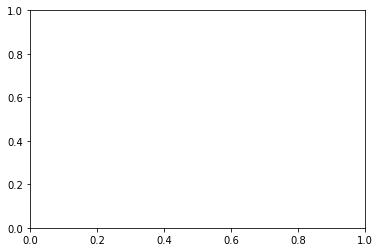

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MatrixMethods as mm
from SingleImage import *
from ImageBlock import *


In [2]:
class Camera:
    def __init__(self, focal_length, sensor_size):
        self.focal_length = focal_length
        self.sensor_size = sensor_size # tuple of (width, height) in mm

In [3]:
# create class for simulate block of images
class SimulateBlock:
    def __init__(self, focal_length, image_size, overlap=0.6 , num_images=2, tie_pattern='3 mid frame', control_pattern='random', rotaions_sigma=5, altitude=100):
        
        self.focal_length = focal_length # in mm
        self.image_size = image_size # tuple of (width, height) in mm
        self.overlap = overlap # in fraction of image size
        self.num_images = num_images
        self.tie_pattern = tie_pattern # '3 mid frame', '4 corners'
        self.control_pattern = control_pattern
        self.rotaions_sigma = rotaions_sigma # in arcsec
        self.altitude = altitude # in m
        self.images = []
        self.tie_points = []
        self.control_points = []
        self.camera = Camera(focal_length, image_size)
        self.block = []
        
    # create image_height and image_width properties
    @property
    def image_height(self):
        return self.image_size[1]
    
    @property
    def image_width(self):
        return self.image_size[0]
    
        
    def simulate_image(self, image_id, camera, tie_pattern, location):
        # simulate tie points
        tie_points = self.simulate_tie_points(tie_pattern, image_id=image_id)
        # simulate rotation angles
        rotation = self.simulate_rotation(self.rotaions_sigma)
        exteriorOrientationParameters = np.concatenate((location, rotation))
        # initialize image
        image = SingleImage(camera, image_id, exteriorOrientationParameters, tie_points)
        
        
        return image
    
    def simulate_tie_points(self, tie_pattern, backoff=0.9, image_id=0):
        """Simulate tie points in the image
        inputs: 
        tie_pattern: '3 mid frame', '4 corners'
        backoff: backoff from the edge of the image in fraction of image size
        outputs:
        tie_points: list of tie points in the image
        """
        if tie_pattern == '3 mid frame':
            tie_points = [(0, -self.image_height/2*(backoff), 'T0', image_id),
                          (0, 0, 'T1', image_id),
                          (0, +self.image_height/2*backoff, 'T2', image_id)]
        elif tie_pattern == '4 corners':
            tie_points = [(-self.image_width/2*backoff, -self.image_height/2*backoff, 'T0', image_id),
                          (self.image_width/2*backoff, -self.image_height/2*backoff, 'T1', image_id),
                          (-self.image_width/2*backoff, self.image_height/2*backoff, 'T2', image_id),
                          (self.image_width/2*backoff, self.image_height/2*backoff, 'T3', image_id)]
        else:
            print('Invalid tie pattern')
            
        # convert to dataframe
        tie_points = pd.DataFrame(tie_points, columns=['x', 'y', 'name', 'image_id'])
        return tie_points

    def simulate_rotation(self, sigma):
        """Simulate rotation angles in arcsec
        inputs:
        sigma: standard deviation of rotation angles in arcsec
        outputs:
        rotation: rotation angles in arcsec
        """
        rotation = np.radians(np.random.normal(0, sigma, 3))        
        return rotation
        
    def simulate_image_locations(self):
        """Simulate image locations
        inputs:
        overlap: overlap between images in fraction of image size
        num_images: number of images
        outputs:
        image_locations: list of image locations
        """
        # calculate image locations
        image_locations = []
        for i in range(self.num_images):
            image_locations.append((i*self.image_width*(1-self.overlap), 0, self.altitude))
        return image_locations

    def simulate_block(self):
        """Simulate block of images
        inputs:
        self
        outputs:
        block: list of images
        """
        # calculate image locations
        image_locations = self.simulate_image_locations()
        
        tie_points = []
        # simulate images
        for i in range(self.num_images):

            image = self.simulate_image(i, self.camera, self.tie_pattern, image_locations[i])
            tie_points.append(image.tie_points)
            self.images.append(image)
        # create block
        block = ImageBlock(self.images, tie_points, self.control_points, None)
        return block
    
    

In [4]:
a = SimulateBlock(50, (36, 24), overlap=0.6 , num_images=4, tie_pattern='4 corners', control_pattern='random', rotaions_sigma=0, altitude=100)

block = a.simulate_block()

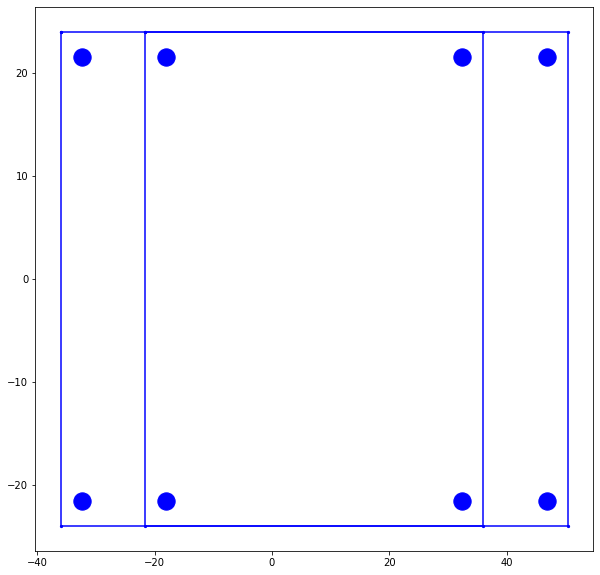

In [5]:
# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

block.images[0].draw_frame(ax)
block.images[0].draw_tie_points(ax)
block.images[1].draw_frame(ax)
block.images[1].draw_tie_points(ax)
plt.show()

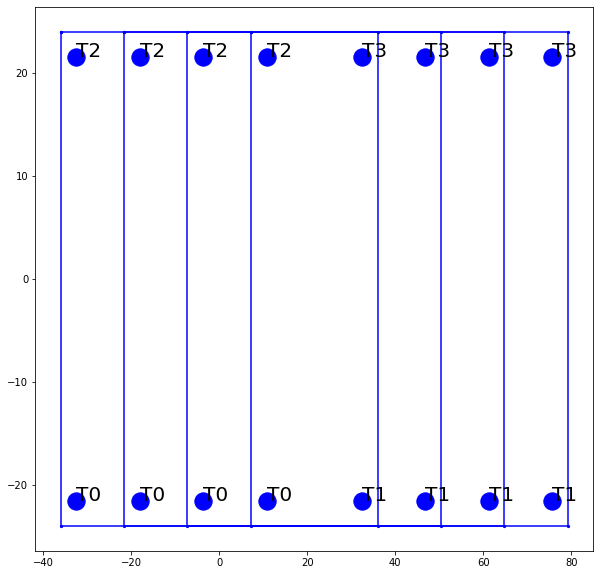

In [6]:
block.draw_block(anotate=True)

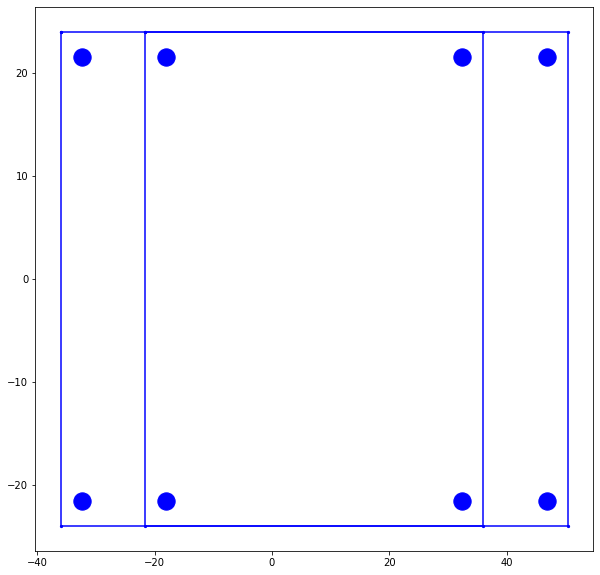

In [7]:
# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

a.images[0].draw_frame(ax)
a.images[0].draw_tie_points(ax)
a.images[1].draw_frame(ax)
a.images[1].draw_tie_points(ax)
plt.show()

In [8]:
print(a.images[0].tie_points)


      x     y name  image_id
0 -16.2 -10.8   T0         0
1  16.2 -10.8   T1         0
2 -16.2  10.8   T2         0
3  16.2  10.8   T3         0
